In [1]:
import geopandas as gpd
import momepy as mm

from itertools import combinations

import numpy as np
import pygeos

from shapely.geometry import LineString
from shapely.ops import polygonize

from scipy.spatial import Voronoi

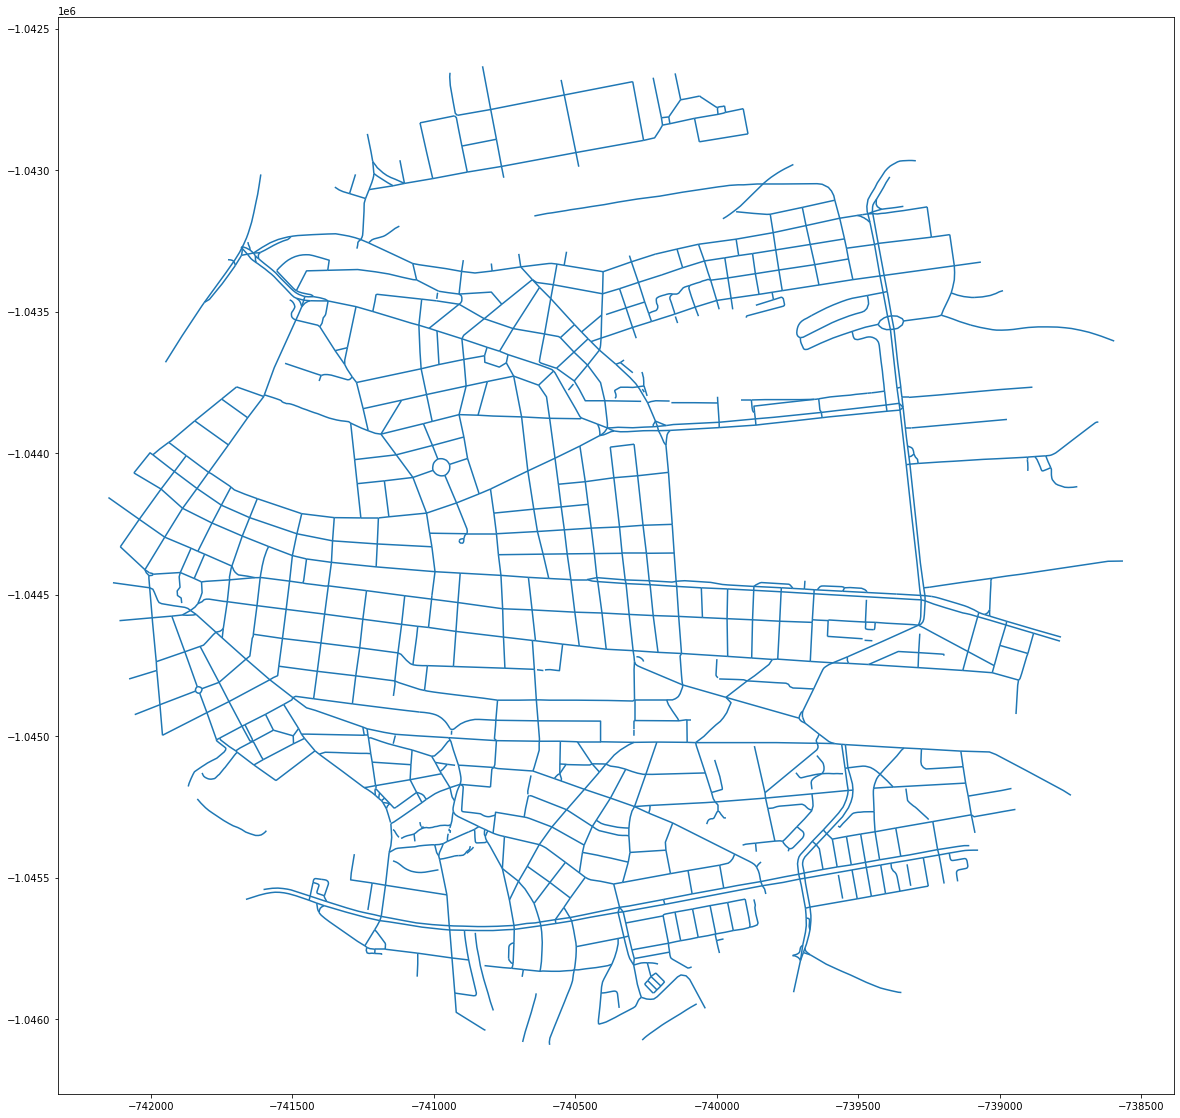

In [7]:
# input
network = gpd.read_file("sample.geojson")
network.plot(figsize=(20, 20))

In [4]:
# helper functions
def get_ids(x, ids):
    return ids[x]


mp = np.vectorize(get_ids, excluded=["ids"])


def dist(p1, p2):
    return np.sqrt(((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2))


def get_verts(x, voronoi_diagram):
    return voronoi_diagram.vertices[x]


def _average_geometry(lines, poly, distance=2):
    """
    Returns average geometry.

    list : LineStrings connected at endpoints forming a closed polygon
    distance : distance for interpolation

    Returns list of averaged geometries
    """
    # get an additional line around the lines to avoid infinity issues with Voronoi
    extended_lines = [poly.buffer(distance).exterior] + lines

    # interpolate lines to represent them as points for Voronoi
    points = np.empty((0, 2))
    ids = []

    pygeos_lines = pygeos.from_shapely(extended_lines)
    lengths = pygeos.length(pygeos_lines)
    for ix, (line, length) in enumerate(zip(pygeos_lines, lengths)):
        pts = pygeos.line_interpolate_point(
            line, np.linspace(0.1, length - 0.1, num=int((length - 0.1) // distance))
        )  # .1 offset to keep a gap between two segments
        points = np.append(points, pygeos.get_coordinates(pts), axis=0)
        ids += [ix] * len(pts)
    
        # here we might also want to append original coordinates of each line
        # to get a higher precision on the corners, but it does not seem to be
        # necessary based on my tests.  
       
    # generate Voronoi diagram
    voronoi_diagram = Voronoi(points)

    # get all rigdes and filter only those between the two lines
    pts = voronoi_diagram.ridge_points
    mapped = mp(pts, ids=ids)

    # iterate over segment-pairs
    edgelines = []
    for a, b in combinations(range(1, len(lines) + 1), 2):
        mask = (
            np.isin(mapped[:, 0], [a, b])
            & np.isin(mapped[:, 1], [a, b])
            & (mapped[:, 0] != mapped[:, 1])
        )
        rigde_vertices = np.array(voronoi_diagram.ridge_vertices)
        verts = rigde_vertices[mask]

        # generate the line in between the lines
        edgeline = pygeos.line_merge(
            pygeos.multilinestrings(get_verts(verts, voronoi_diagram))
        )
        snapped = pygeos.snap(edgeline, pygeos_lines[a], distance)
        edgelines.append(snapped)
    return edgelines


def consolidate(network, distance=2, epsilon=2):
    '''
    Consolidate edges of a network, takes care of geometry only. No
    attributes are preserved at the moment.

    The whole process is split into several steps:
    1. Polygonize network
    2. Find polygons which are likely caused by dual lines and other
       geometries to be consolidated.
    3. Iterate over those polygons and generate averaged geometry
    4. Remove invalid and merge together with new geometry.

    Step 2 needs work, this is just a first attempt based on shape and area
    of the polygon. We will have to come with clever options here and 
    allow their specification, because each network will need different
    parameters.

    Either before or after these steps needs to be done node consolidation,
    but in a way which does not generate overlapping geometries.
    Overlapping geometries cause (unresolvable) issues with Voronoi.

    Parameters
    ----------
    network : GeoDataFrame (LineStrings)

    distance : float
        distance for interpolation

    epsilon : float
        tolerance for simplification

    '''

    # polygonize network
    crs = network.crs
    polygonized = polygonize(network.geometry)
    geoms = [g for g in polygonized]
    gdf = gpd.GeoDataFrame(geometry=geoms, crs=network.crs)


    # filter potentially incorrect polygons - TODO
    max_size = 10000
    size = 5000
    circom_max = 0.2
    # calculate parameters
    gdf["area"] = gdf.geometry.area
    gdf["circom"] = mm.CircularCompactness(gdf, "area").series
    # select valid and invalid network-net_blocks
    possible = gdf.loc[gdf["area"] < max_size]
    invalid = possible.loc[
        (possible["circom"] < circom_max)
    ]

    sindex = network.sindex

    # iterate over polygons which are marked to be consolidated
    # list segments to be removed and the averaged geoms replacing them
    averaged = []
    to_remove = []
    for poly in invalid.geometry:
        bounds_index = list(sindex.intersection(poly.bounds))
        potential = network.iloc[bounds_index]
        real = network.intersection(poly.exterior)
        mask = real.intersection(poly.exterior).type.isin(["LineString", "MultiLineString"])
        real  = real[mask]
        lines = list(real.geometry)
        to_remove += list(real.index)

        if lines:
            av = _average_geometry(lines, poly, distance)
            averaged += av

    # drop double lines
    clean = network.drop(set(to_remove))
    
    # merge new geometries with the existing network
    result = gpd.GeoSeries(averaged).simplify(epsilon).append(clean.geometry)
    result.crs = crs
    
    # here we have to merge lines which are supposed to be merged (eliminate nodes of degree 2)
    # could be done using momepy.network_false_nodes if we care only about the geometry

    return result

In [5]:
av = consolidate(network, 2)

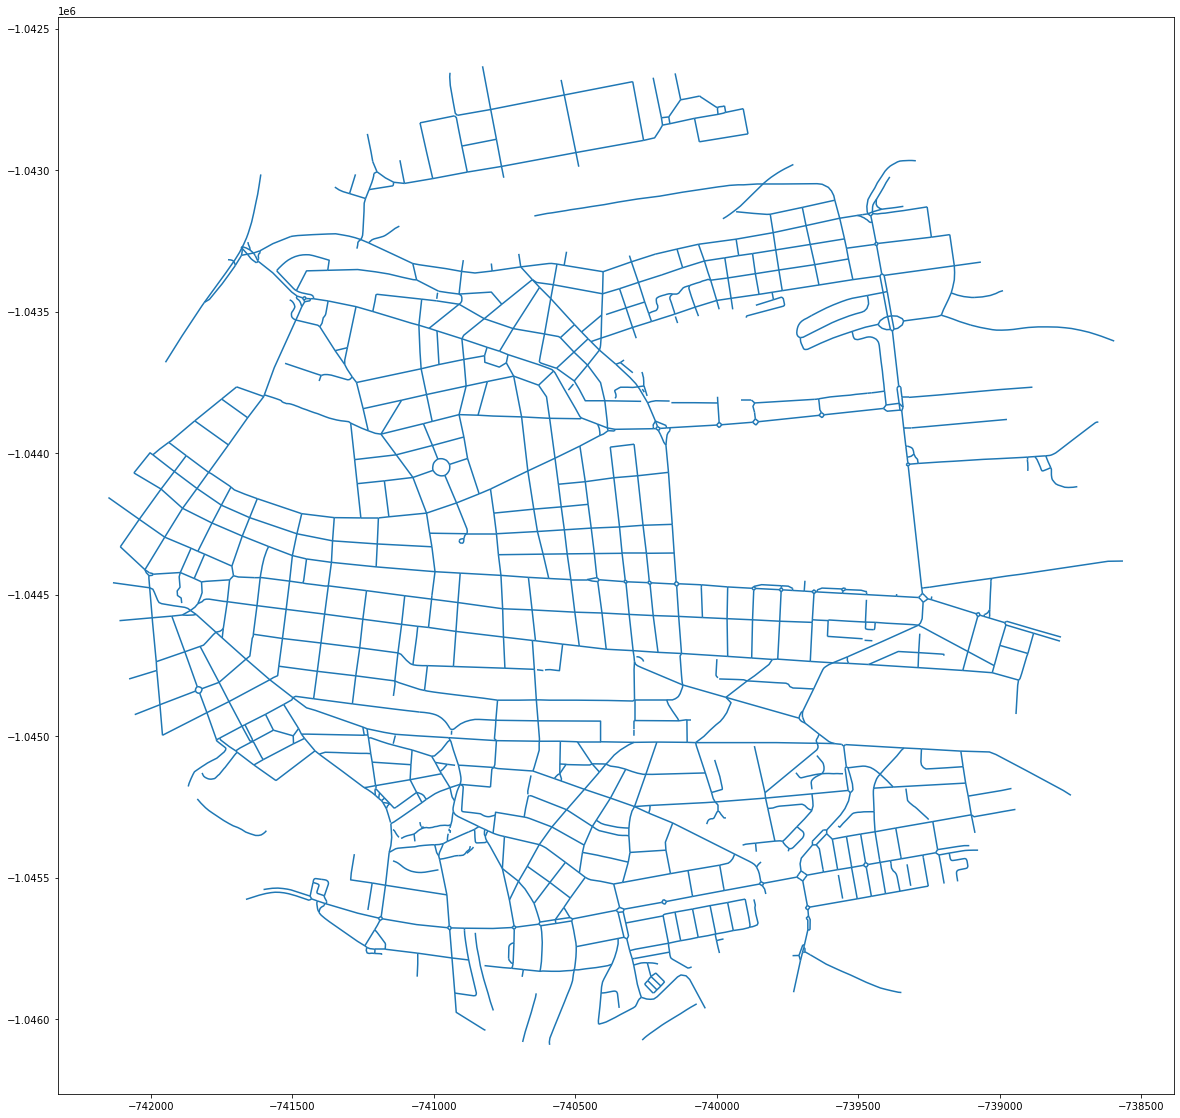

In [6]:
av.plot(figsize=(20, 20))

TODO:

- figure out clever way of adaptable filters (to identify which polygons should not be there, i.e. which edges should be consolidated)
- triple/quadruple lines
- consolidate nodes in geometrical manner before (or after) edge consolidation. Current implementation of node consolidation creates overlapping lines causing issues with Voronoi. The optimal result should be spider-like.
- implementation into OSMnx, which has to deal with a mess of OSM (overlapping geometries)
- make it work for both GeoDataFrames and Graph